<a href="https://colab.research.google.com/github/MeriemTerki/Store-Item-Demand-Forecasting-Encoder-Decoder-LSTM-Network/blob/main/Store_Item_Demand_Forecasting_Encoder_Decoder_LSTM_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
import pandas_datareader as web
import datetime as dt

# ML/DL imports
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

## Helper Functions

In [ ]:
# split a univariate sequence into samples
def split_sequence(data, days_past, days_future):
    X, y = list(), list()
    
    for i in range(len(data)):        
        # find the end of this pattern
        end_ix = i + days_past
        out_end_ix = end_ix + days_future
        
        # check if we are beyond the sequence
        if out_end_ix > len(data):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

## Reading and Preparing the Data

In [ ]:
file_name = '/content/drive/MyDrive/DeepLearningProjects/Store-Item Demand Forecasting/train.csv'
dataset = pd.read_csv(file_name, parse_dates=['date'])

dataset.drop(labels=['store', 'item'], axis=1, inplace = True)

In [ ]:
dataset.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [ ]:
dataset.describe()

,sales
count,913000.000000
mean,52.250287
std,28.801144
min,0.000000
25%,30.000000
50%,47.000000
75%,70.000000
max,231.000000


## Time period of the dataset

In [ ]:
print('Min date from train set: %s' % dataset.date.min().date())
print('Max date from train set: %s' % dataset.date.max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


## Checking for NaN (missing values) in the dataframe

In [ ]:
dataset.sales.isnull().sum()

0

no missing data

## Splitting the data set in training and test sets
This part is important since we will be using the training set to train the model and the test set to check if the model does well on unseen inputs.

We are going to use only a small subset of the data due to training time. In competitons, use as much data that there is avaialable to botrain a stronger model that is good at generalizing.

In [ ]:
training_data = dataset[(dataset['date'] <= '2016')]
test_data = dataset[(dataset['date'] >= '2017')]

training_data.sort_values('date', inplace=True)
training_data = training_data.groupby('date')
training_data = training_data.agg({'sales':'mean'})
training_data.colums = ['sales']

test_data.sort_values('date', inplace=True)
test_data = test_data.groupby('date')
test_data = test_data.agg({'sales':'mean'})
test_data.colums = ['sales']

print(len(training_data))
print(len(test_data))

1096
365


In [ ]:
training_data.head()

,sales
date,
2013-01-01,27.392
2013-01-02,27.356
2013-01-03,28.976
2013-01-04,31.354
2013-01-05,32.474


## Visualizing and Plotting our Data
It is very important to plot and visualize the data to get a good grasp of what is happening. For this, I have decided to use plotly, but you can use any other visualizaiton library such as seaborn and matplotlib. We are using plotly graph objects since we will need to create subplots later.

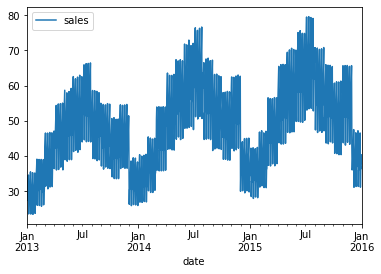

In [ ]:
training_data[["sales"]].plot()
plt.show(block=True)

Now to plot the training and test data on the same plot. Notice the lag between the training data and test data. This is done on purpose to ensure that the test data isn't too strongly correlated to the training data.

<Figure size 2400x1200 with 0 Axes>

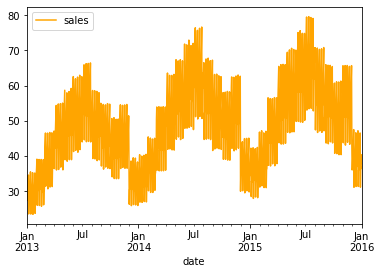

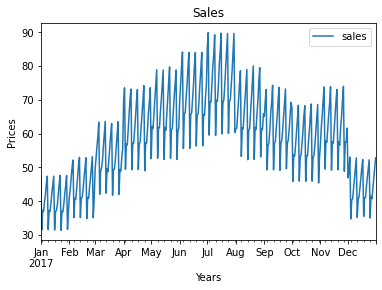

In [ ]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
training_data[["sales"]].plot(label='sales', color='orange')
test_data[["sales"]].plot(label='sales')

  
# adding title to the plot
plt.title('Sales')
  
# adding Label to the x-axis
plt.xlabel('Years')

# adding Label to the y-axis
plt.ylabel('Prices')
  
# adding legend to the curve
plt.legend()



## Scaling the training data
Here we will use MinMaxScaler from the Sci-kit learn library to standardize and scale our input data between 0-1.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_tain_data = scaler.fit_transform(training_data.values.reshape(-1,1))
scaled_tain_data.shape

(1096, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_test_data = scaler.fit_transform(test_data.values.reshape(-1,1))
scaled_test_data.shape

(365, 1)

Transforming the data into a time-series appropriate problem
We will now have to rpepare the data in a form that is appropriate to be fed into a RNN/LSTM network. The key is to seperate the data into past sequence (Day 0-29) that is going to be used to predict the future sequence (Day 30-34) for example.

In [ ]:
days_past = 30   # use past 30 time steps to predict
days_future = 5  # predict 5 time steps in the future

x_train, y_train = split_sequence(scaled_tain_data, days_past, days_future)
x_test, y_test = split_sequence(scaled_test_data, days_past, days_future)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(1062, 30, 1)
(331, 30, 1)


The LSTM model expects the input to have shape: (Samples, Timesteps, Number of feautures). In our case, we have an univariate RNN problem, therefore Number of feautures = 1



In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

In [ ]:
print(x_train.shape)
print(x_test.shape)

(1062, 30, 1)
(331, 30, 1)


## Creating the LSTM Network
We are going to be creating a three layer LSTM Network with a dense layer at the end. We are using dropout as a regularisation method to combat overffiting

In [ ]:
def encoder_decoder_model():
    
    # Use Keras sequential model
    model = Sequential()
    
    # Encoder LSTM layer with Dropout regularisation; Set return_sequences to False since we are feeding last output to decoder layer
    model.add(LSTM(100, activation='relu',input_shape = (days_past,1)))
    model.add(Dropout(0.2))
    
    # The fixed-length output of the encoder is repeated, once for each required time step in the output sequence with the RepeatVector wrapper
    model.add(RepeatVector(days_future))
    
    # Decoder LSTM layer with Dropout regularisation; Set return_sequences to True to feed each output time step to a Dense layer
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    
    # Same dense layer is repeated for each output timestep with the TimeDistributed wrapper
    model.add(TimeDistributed(Dense(units=1, activation = "linear")))
    
    return model

In [ ]:
model = encoder_decoder_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 5, 100)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 time_distributed (TimeDistr  (None, 5, 1)             101       
 ibuted)                                                

Now we set our compiler and our optimatization mechanism. We will be using the Adam optimazation method since it is widely used and performs much better than regular gradient descent.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

## Training/Fitting time
We can finally train our model with our training data. Let's see how it does.

In [ ]:
checkpointer = ModelCheckpoint(filepath = './checkpoint.hdf5', verbose = 0, save_best_only = True)
his=model.fit(x_train,y_train,epochs=50,callbacks=[checkpointer], verbose=0)

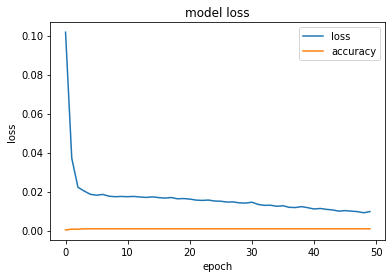

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'])
plt.show()

We see that the loss decreaes and is lower than 0.2 MSE. This shows that our model is indeed doing well on the training data

## Testing Time

In [ ]:
# Predicting the prices
predicted_sales = model.predict(x_test)


## Test Visualization

In [ ]:
# We upse numpy squeeze to transform (samples, timesteps, number of features) into (samples, timesteps), since that is what inverse_transform expects
y_test = scaler.inverse_transform(np.squeeze(y_test))
predicted_sales = scaler.inverse_transform(np.squeeze(predicted_sales))


# We flatten the 2 dimensional array so we can plot it with matplotlib
y_test = y_test.flatten()
predicted_sales = predicted_sales.flatten()

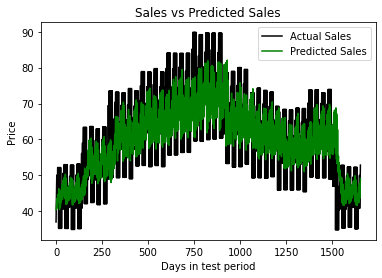

In [ ]:
plt.plot(y_test, color='black', label=f"Actual Sales")
plt.plot(predicted_sales, color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend()
plt.show()